In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [58]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])
train_data = datasets.ImageFolder(root='D:/xuexi/CV/archive/Fast Food Classification V2/Train', transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [59]:
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

mean, std = calculate_mean_std(train_loader)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.6674, 0.5378, 0.4099])
Std: tensor([0.2691, 0.2820, 0.3093])


In [60]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_data = datasets.ImageFolder(root='D:/xuexi/CV/archive/Fast Food Classification V2/Train', transform=transform)
test_data = datasets.ImageFolder(root='D:/xuexi/CV/archive/Fast Food Classification V2/Test', transform=transform)
validation_data = datasets.ImageFolder(root='D:/xuexi/CV/archive/Fast Food Classification V2/Valid', transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, pin_memory=True)

model = models.inception_v3(pretrained=True).to(device)

In [61]:
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'Mixed_7' in name:
        param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),
    nn.Linear(128, 10) 
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-3) 

In [62]:
def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=10):
    train_losses = []
    valid_losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0
        total = 0

        train_loop = tqdm(train_loader, leave=True) 
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.01 * loss2

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
            train_loop.set_postfix(train_loss=loss.item())

        model.eval()
        valid_loop = tqdm(validation_loader, leave=True) 
        with torch.no_grad():
            for inputs, labels in valid_loop:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                valid_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
                valid_loop.set_postfix(valid_loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(validation_loader)
        accuracy = correct / total

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}，Accuracy: {accuracy}')

    return model, train_losses, valid_losses, accuracies

model, train_losses, valid_losses, accuracies = train_model(model, criterion, optimizer, train_loader, validation_loader)

Epoch [1/10]: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s, valid_loss=1.14] 


Epoch 1, Train Loss: 1.7164799924624168, Validation Loss: 0.9851313041789191，Accuracy: 0.7308571428571429


Epoch [2/10]: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s, valid_loss=0.616]


Epoch 2, Train Loss: 0.8730669425705732, Validation Loss: 0.6747949889728001，Accuracy: 0.8071428571428572


Epoch [3/10]: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s, valid_loss=0.527]


Epoch 3, Train Loss: 0.5867213687654269, Validation Loss: 0.5831731227891785，Accuracy: 0.8274285714285714


Epoch [4/10]: 100%|██████████| 28/28 [00:14<00:00,  1.93it/s, valid_loss=0.363]


Epoch 4, Train Loss: 0.4066036265280287, Validation Loss: 0.5411456163440432，Accuracy: 0.8457142857142858


Epoch [5/10]: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s, valid_loss=0.687]


Epoch 5, Train Loss: 0.2907439006839768, Validation Loss: 0.5625199547835759，Accuracy: 0.8397142857142857


Epoch [6/10]: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s, valid_loss=0.743]


Epoch 6, Train Loss: 0.21472219743971097, Validation Loss: 0.61704128661326，Accuracy: 0.8388571428571429


Epoch [7/10]: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s, valid_loss=0.351]


Epoch 7, Train Loss: 0.17354344071473105, Validation Loss: 0.5867096089891025，Accuracy: 0.842


Epoch [8/10]: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s, valid_loss=0.66] 


Epoch 8, Train Loss: 0.15221051947545197, Validation Loss: 0.5908802524209023，Accuracy: 0.8468571428571429


Epoch [9/10]: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s, valid_loss=0.573]


Epoch 9, Train Loss: 0.13779592469839727, Validation Loss: 0.6189405737178666，Accuracy: 0.8425714285714285


Epoch [10/10]: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s, valid_loss=0.412]

Epoch 10, Train Loss: 0.12816262819756896, Validation Loss: 0.5886256524494716，Accuracy: 0.8534285714285714


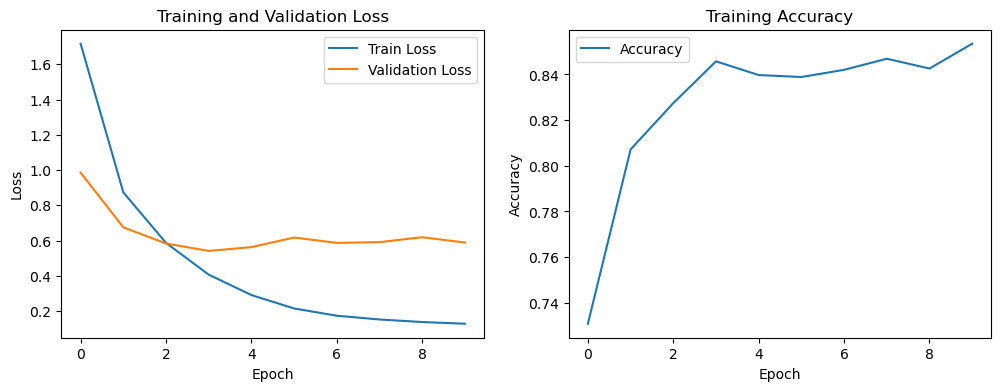

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Test Loss: 0.5199, Test Accuracy: 87.00%
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.86      0.96      0.91       100
        Burger       0.94      0.83      0.89       200
Crispy Chicken       0.87      0.95      0.91       100
         Donut       0.95      0.94      0.95       200
         Fries       0.87      0.91      0.89       100
       Hot Dog       0.91      0.81      0.86       200
         Pizza       0.93      0.92      0.93       200
      Sandwich       0.89      0.91      0.90       200
          Taco       0.62      0.90      0.74       100
       Taquito       0.65      0.51      0.57       100

      accuracy                           0.87      1500
     macro avg       0.85      0.86      0.85      1500
  weighted avg       0.88      0.87      0.87      1500



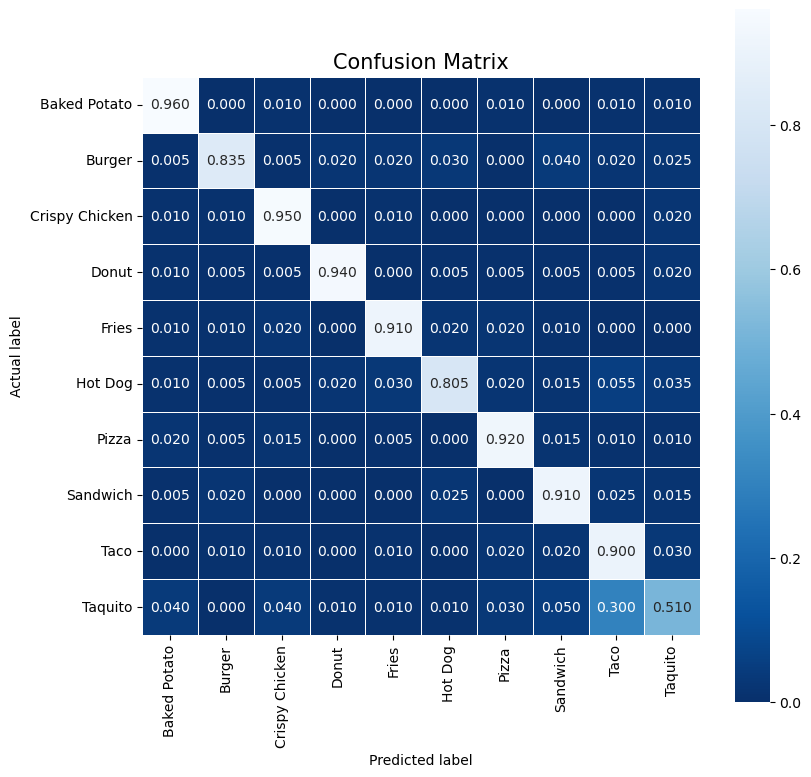

In [68]:
def test_model(model, test_loader, criterion):
    model.eval()  
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    test_loop = tqdm(test_loader, leave=True)
    with torch.no_grad(): 
        for inputs, labels in test_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    class_names = test_data.classes
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(9,9))
    sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size = 15)

    cr = classification_report(true_labels, predictions, target_names=test_loader.dataset.classes)
    print('Classification Report:')
    print(cr)

test_model(model, test_loader, criterion)

In [69]:
def get_misclassified(model, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    model.eval()

    test_loop = tqdm(test_loader, leave=True)
    with torch.no_grad():
        for data, labels in test_loop:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(labels.view_as(pred)) == False).squeeze()
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = labels.view_as(pred)[list_misclassified]

            misclassified.append(batch_misclassified.cpu())
            misclassified_pred.append(batch_mis_pred.cpu())
            misclassified_target.append(batch_mis_target.cpu())

    # group all the batches together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

misclassified = get_misclassified(model, test_loader)

100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


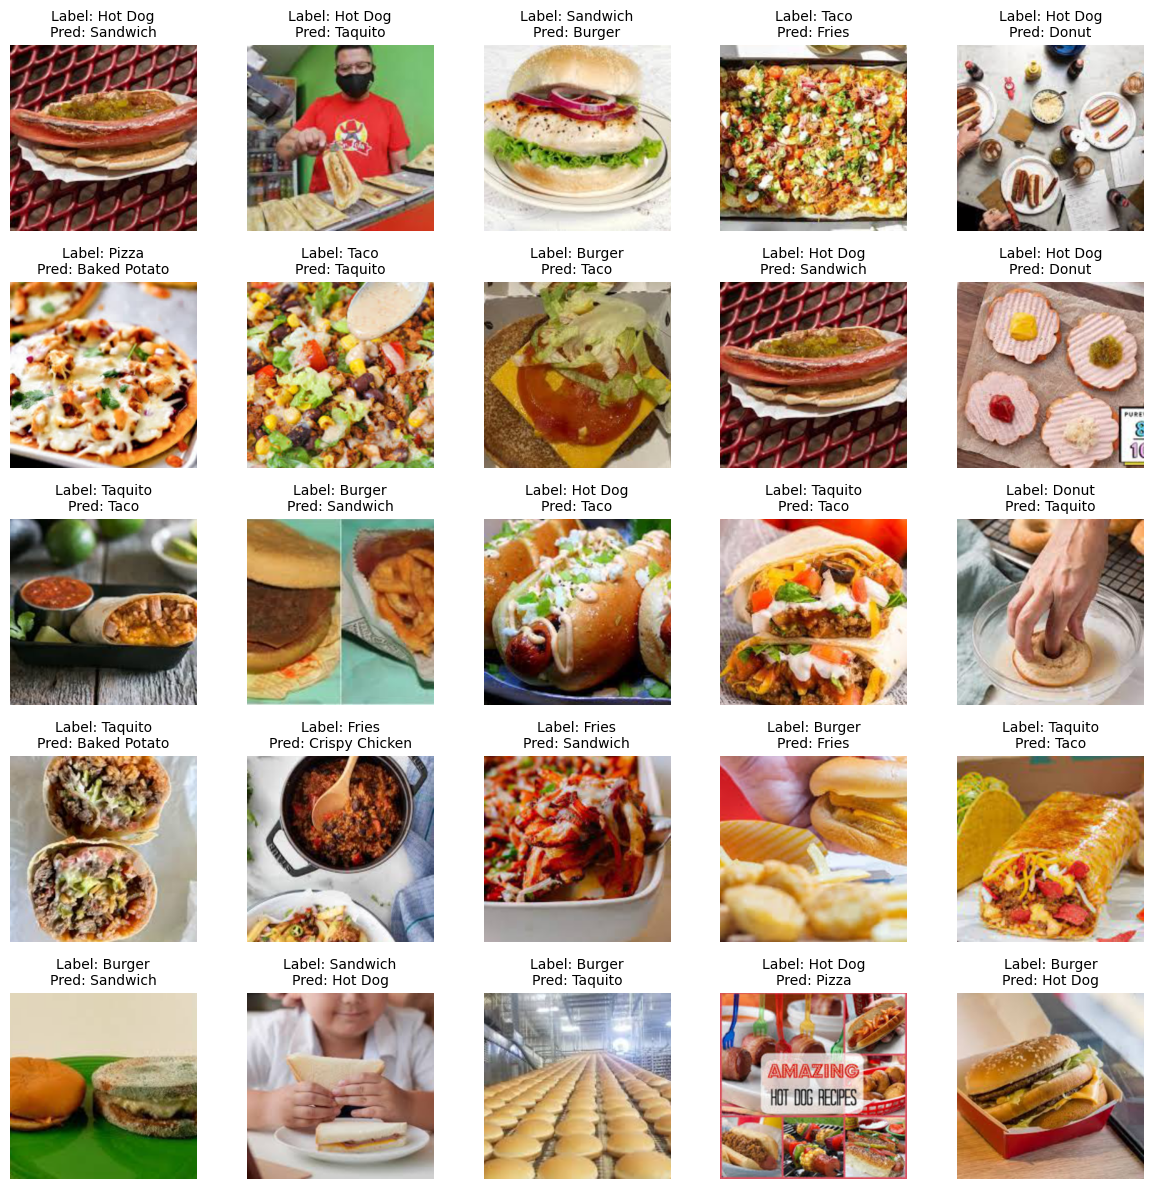

In [70]:
import random

num_images = 25
fig = plt.figure(figsize=(12, 12))

for idx, (image, pred, label) in enumerate(random.choices(misclassified, k=num_images)):
    image = np.transpose(image, (1, 2, 0)) 
    image = image * std + mean  
    image = np.clip(image, 0, 1)  

    class_names = test_data.classes
    pred_name = class_names[pred.item()]
    label_name = class_names[label.item()]

    ax = fig.add_subplot(5, 5, idx + 1)
    ax.axis('off')
    ax.set_title(f'Label: {label_name}\nPred: {pred_name}', fontsize=10)
    ax.imshow(image)

plt.tight_layout()
plt.show()